In [1]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload
import winsound
import dill, wandb
import datetime as dt
wandblog=0
if wandblog:
    !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf
run_counter=0

Notebook
GPU detected


In [2]:
tf.__version__, spektral.__version__

('2.4.1', '1.0.3')

In [3]:
################################################
# Setup Deafult Variables                       # 
################################################
learning_rate = 5e-4
batch_size    = 512//4
epochs        = 20
n_data       = 1e4
scenario    = "GAT_test"+str(run_counter)
patience = 20

################################################
# Setup Hyperparameters                        # 
################################################
hidden_states = 'N/A'
forward       = False
dropout       = 'None'
loss_method   = "von Mises"
n_neighbors   = 6 # SKRIV SELV IND

In [4]:
################################################
# Load data                      # 
################################################

import data_load as dl
reload(dl)
graph_data=dl.graph_data
dataset=graph_data(n_data=n_data, restart=1, transform=True, angle=True, unitvec=False)
idx_lists = dataset.index_lists
# Split data
dataset_train = dataset[idx_lists[0]]
dataset_val   = dataset[idx_lists[1]]
dataset_test  = dataset[idx_lists[2]]

loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size) # the different loaders work very very differently, beware
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)

winsound.Beep(400,300)

Not notebook
Not notebook
Removed and ready to reload
Connecting to db-file
Loading Muons
Reading files


C:\Users\chris\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\chris\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
  1%|█                                                                           | 143/10000 [00:00<00:06, 1418.78it/s]

Splitting data to events
     dom_x    dom_y    dom_z      time  charge_log10  SRTInIcePulses
0 -0.25614 -0.52108  0.29178 -0.902557     -0.088028               0
1  0.50527  0.25788 -0.20864 -1.099296      0.378965               0
2 -0.06670  0.27692  0.00422  0.424602      0.791982               0
3  0.30341  0.33564  0.03637 -0.125602      1.160970               0
4  0.30341  0.33564  0.03637 -0.114116     -1.656923               0
   energy_log10    zenith   azimuth
0      2.422178  0.914194  0.967663
1      2.311812  1.155833  5.953112
2      3.433424  1.205342  2.802480
3      2.582473  0.518382  4.915968
4      2.783172  0.709137  5.187095
Generating adjacency matrices


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1428.40it/s]


Saving dataset
Loading data to memory


In [5]:
def metrics_angle(y_reco, y_true):
    energy_quantiles = tfp.stats.percentile(tf.subtract(y_true[:, 0], y_reco[:, 0]), [25, 75]) 
    w_energy         = (energy_quantiles[1] - energy_quantiles[0]) / 1.349
    
    alpha= tf.math.acos(tf.math.sin(y_reco[:, 1])*tf.math.sin(y_true[:, 1])*tf.math.cos(tf.subtract(y_reco[:, 2],y_true[:, 2]))+tf.math.cos(y_reco[:, 1])*tf.math.cos(y_true[:, 1]))
    # tf.print(alpha)
    angle_resi = 180 / np.pi * alpha #degrees
    u_angle         = tfp.stats.percentile(angle_resi, [0,50,68])

    return float(w_energy.numpy()), float(u_angle[2].numpy()) 

metrics=metrics_angle

In [6]:
# def loss_func(y_reco, y_true, re=False):

    
# loss_func    

In [7]:
def test_angle(loader, plot=True):
    '''Function to test and plot performance of Graph DL
    input should be dom pos x,y,z , time, charge(log10)
    target should be energy(log10),zenith angle, azimuthal angle, NOT unit vec 
    '''
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()

    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_reco[idx, :], y_true[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)

    if plot:
        fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 6))

        for a in ax:
            a_ = a.twinx()
            a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
            a_.set_yscale("log")
            a.set_xlabel("Log Energy")
        
        ax_top = ax

        # Energy reconstruction
        ax_top[0].scatter(xs, w_energies)
        ax_top[0].set_title("Energy Performance")
        ax_top[0].set_ylabel(r"$w(\Delta log(E)$")

        # Angle reconstruction
        ax_top[1].scatter(xs, u_angles)
        ax_top[1].set_title("Angle Performance")
        ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")

        return fig, ax

In [8]:
if wandblog:
    #checks
    wandb.init(project="icecube", name=scenario,entity="chri862z")

    # Declare for log
    wandb.config.hidden_states = hidden_states
    wandb.config.hidden_states = n_data
    wandb.config.forward = forward
    wandb.config.dropout = dropout
    wandb.config.learning_rate = learning_rate
    wandb.config.batch_size = batch_size
    wandb.config.loss_func = loss_method
    wandb.config.n_neighbors = n_neighbors
    wandb.config.optimizer = 'Adam'

In [11]:
################################################
# Load Model and do checks                      # 
################################################
# import models.GCN0 as m
import models.GCS as m
reload(m)
model=m.model(n_out=3)

In [43]:
# ################################################
# # Setup functions                            # 
# ################################################
import loss.loss_funcs as loss_funcs
reload(loss_funcs)
loss_func=loss_funcs.loss_funcangle

def lr_schedule(epochs = epochs, initial = learning_rate, decay = 0.9):
    n = 1
    lr = initial
    yield lr
    while n < 3:
        lr *= 2
        n  += 1
        yield lr
    while True:
        lr *= decay
        n  += 1 
        yield lr


#make functions into tf functions

@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training = True)
        targets     = tf.cast(targets, tf.float32)
        loss        = loss_func(predictions, targets)
        loss       += sum(model.losses)

    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 
    out         = loss_func(predictions, targets)

    return predictions, targets, out


def validation(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)
    
    y_reco  = tf.concat(prediction_list, axis = 0)
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32)

    # w_energy, u_pos, u_angle = metrics(y_reco, y_true) #still missing something
    loss, losses = loss_func(y_reco, y_true, re=True)

    return loss, losses, metrics(y_reco, y_true)



opt = Adam(learning_rate)

In [44]:
run_counter+=1
k=0.2
tot_time=0
current_batch = 0
current_epoch = 1
loss          = 0
lowest_loss   = np.inf
early_stop    = 1
early_stop_counter    = 0
pbar0          = tqdm(total = epochs, position = 0, leave = True)
pbar0.set_description(f"Epochbar")
pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)
start_time    = time.time()
lr_gen        = lr_schedule(initial=learning_rate)
learning_Rate = next(lr_gen)
cwd = osp.abspath('')
save_path = osp.join(cwd, 'trained_models/'+scenario)
if not osp.isdir(save_path):
    os.makedirs(save_path)
    print('New folder for saving '+scenario+' made')
# Implement saving model archictecture to wandb
for batch in loader_train:
    inputs, targets = batch
    out             = train_step(inputs, targets)
    loss           += out
    if current_epoch==1 and current_batch==0:
        model.summary()
    
    current_batch  += 1
    pbar.update(1)
    pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
    
    
    if current_batch == loader_train.steps_per_epoch:
        t=time.time() - start_time
        tot_time+=t
        print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
        print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

        loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
#         val_loss, val_loss_from, val_metric = validation(loader_val)
        val_loss, val_loss_from, val_metric = validation(loader_val)
        if wandblog:
            wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
                       "Validation Loss": val_loss, 
                       "Energy metric":   val_metric[0],
                       "Angle metric":    val_metric[1],
                       "Learning rate":   learning_rate})

        print(f"Avg loss of validation: {val_loss:.6f}")
        print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
        print(f"Energy: w = {val_metric[0]:.6f} \t Angle: u = {val_metric[1]:.6f}")

        if val_loss < lowest_loss:
            early_stop_counter = 0
            lowest_loss        = val_loss
        else:
            early_stop_counter += 1
        print(f'Early stop counter: {early_stop_counter}/{patience}, lowest loss was {lowest_loss:.6f}')
        if early_stop and (early_stop_counter >= patience):
            model.save(save_path)
            print(f"Stopped training. No improvement was seen in {patience} epochs")
            break

        if current_epoch != epochs:
            pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)

        learning_rate = next(lr_gen)
        opt.learning_rate.assign(learning_rate)
        pbar0.update(1)
        time_avg=tot_time/current_epoch
        delta=dt.timedelta(seconds=time_avg*(epochs-current_epoch))
        now = dt.datetime.now()
        then=now+delta
        time_e = then.strftime("%H:%M:%S")
        pbar0.set_description(f"Expect to finish at {time_e}")
#         if current_epoch % 10 == 0:
#             model.save(save_path)
#             print("Model saved")

        loss            = 0
        start_time      = time.time()
        current_epoch  += 1
        current_batch   = 0
winsound.Beep(400,300)



Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ecc_conv_4 (ECCConv)         multiple                  29696     
_________________________________________________________________
gcn_conv_16 (GCNConv)        multiple                  4096      
_________________________________________________________________
gcn_conv_17 (GCNConv)        multiple                  8192      
_________________________________________________________________
gcn_conv_18 (GCNConv)        multiple                  32768     
_________________________________________________________________
gcn_conv_19 (GCNConv)        multiple                  131072    
_________________________________________________________________
global_max_pool_4 (GlobalMax multiple                  0         
_________________________________________________________________
global_avg_pool_4 (GlobalAvg multiple                  0 

Epoch 2 of 20 done in 12.69 seconds using learning rate: 8.24E-04
Avg loss of train: 1.745339
Avg loss of validation: 1.081059
Loss from:  Energy: 0.814367 	 Angle: 0.266692 
Energy: w = 0.579207 	 Angle: u = 48.586937
Early stop counter: 0/20, lowest loss was 1.081059



Epoch 3 of 20 done in 14.19 seconds using learning rate: 1.65E-03
Avg loss of train: 0.591356
Avg loss of validation: 0.850731
Loss from:  Energy: 0.527311 	 Angle: 0.323421 
Energy: w = 0.592667 	 Angle: u = 52.252316
Early stop counter: 0/20, lowest loss was 0.850731


Epoch 4 of 20 done in 16.91 seconds using learning rate: 1.48E-03
Avg loss of train: 0.474850
Avg loss of validation: 0.618990
Loss from:  Energy: 0.348658 	 Angle: 0.270332 
Energy: w = 0.393529 	 Angle: u = 48.459934
Early stop counter: 0/20, lowest loss was 0.618990



Epoch 5 of 20 done in 17.33 seconds using learning rate: 1.33E-03
Avg loss of train: 0.454072
Avg loss of validation: 0.631004
Loss from:  Energy: 0.380559 	 Angle: 0.250445 
Energy: w = 0.253910 	 Angle: u = 47.652130
Early stop counter: 1/20, lowest loss was 0.618990


Epoch 6 of 20 done in 14.26 seconds using learning rate: 1.20E-03
Avg loss of train: 0.444233
Avg loss of validation: 0.510791
Loss from:  Energy: 0.263520 	 Angle: 0.247271 
Energy: w = 0.319489 	 Angle: u = 46.475624
Early stop counter: 0/20, lowest loss was 0.510791



Epoch 7 of 20 done in 14.34 seconds using learning rate: 1.08E-03
Avg loss of train: 0.435275
Avg loss of validation: 0.566168
Loss from:  Energy: 0.316617 	 Angle: 0.249551 
Energy: w = 0.391698 	 Angle: u = 47.186134
Early stop counter: 1/20, lowest loss was 0.510791


Epoch 8 of 20 done in 16.87 seconds using learning rate: 9.73E-04
Avg loss of train: 0.430407
Avg loss of validation: 0.500224
Loss from:  Energy: 0.248672 	 Angle: 0.251552 
Energy: w = 0.291511 	 Angle: u = 47.629753
Early stop counter: 0/20, lowest loss was 0.500224



Epoch 9 of 20 done in 14.49 seconds using learning rate: 8.75E-04
Avg loss of train: 0.424717
Avg loss of validation: 0.446196
Loss from:  Energy: 0.198457 	 Angle: 0.247739 
Energy: w = 0.207225 	 Angle: u = 46.336399
Early stop counter: 0/20, lowest loss was 0.446196


Epoch 10 of 20 done in 18.24 seconds using learning rate: 7.88E-04
Avg loss of train: 0.416475
Avg loss of validation: 0.472714
Loss from:  Energy: 0.206991 	 Angle: 0.265723 
Energy: w = 0.236311 	 Angle: u = 48.464111
Early stop counter: 1/20, lowest loss was 0.446196



Epoch 11 of 20 done in 17.16 seconds using learning rate: 7.09E-04
Avg loss of train: 0.410245
Avg loss of validation: 0.441305
Loss from:  Energy: 0.205532 	 Angle: 0.235773 
Energy: w = 0.209485 	 Angle: u = 45.191437
Early stop counter: 0/20, lowest loss was 0.441305


Epoch 12 of 20 done in 22.83 seconds using learning rate: 6.38E-04
Avg loss of train: 0.405421
Avg loss of validation: 0.419823
Loss from:  Energy: 0.188823 	 Angle: 0.231000 
Energy: w = 0.213224 	 Angle: u = 44.031803
Early stop counter: 0/20, lowest loss was 0.419823



Epoch 13 of 20 done in 21.69 seconds using learning rate: 5.74E-04
Avg loss of train: 0.403170
Avg loss of validation: 0.415425
Loss from:  Energy: 0.176894 	 Angle: 0.238532 
Energy: w = 0.200933 	 Angle: u = 45.682785
Early stop counter: 0/20, lowest loss was 0.415425


Epoch 14 of 20 done in 24.74 seconds using learning rate: 5.17E-04
Avg loss of train: 0.395430
Avg loss of validation: 0.481867
Loss from:  Energy: 0.214345 	 Angle: 0.267522 
Energy: w = 0.232913 	 Angle: u = 48.872189
Early stop counter: 1/20, lowest loss was 0.415425



Epoch 15 of 20 done in 22.78 seconds using learning rate: 4.65E-04
Avg loss of train: 0.388196
Avg loss of validation: 0.431489
Loss from:  Energy: 0.183718 	 Angle: 0.247771 
Energy: w = 0.207013 	 Angle: u = 46.591808
Early stop counter: 2/20, lowest loss was 0.415425


Epoch 16 of 20 done in 21.48 seconds using learning rate: 4.19E-04
Avg loss of train: 0.387743
Avg loss of validation: 0.453329
Loss from:  Energy: 0.210400 	 Angle: 0.242929 
Energy: w = 0.250435 	 Angle: u = 46.216518
Early stop counter: 3/20, lowest loss was 0.415425



Epoch 17 of 20 done in 20.87 seconds using learning rate: 3.77E-04
Avg loss of train: 0.378075
Avg loss of validation: 0.396801
Loss from:  Energy: 0.180872 	 Angle: 0.215929 
Energy: w = 0.206279 	 Angle: u = 43.304184
Early stop counter: 0/20, lowest loss was 0.396801


Epoch 18 of 20 done in 17.62 seconds using learning rate: 3.39E-04
Avg loss of train: 0.372781
Avg loss of validation: 0.404990
Loss from:  Energy: 0.185199 	 Angle: 0.219790 
Energy: w = 0.210341 	 Angle: u = 42.984249
Early stop counter: 1/20, lowest loss was 0.396801



Epoch 19 of 20 done in 19.95 seconds using learning rate: 3.05E-04
Avg loss of train: 0.367149
Avg loss of validation: 0.401911
Loss from:  Energy: 0.180824 	 Angle: 0.221087 
Energy: w = 0.206225 	 Angle: u = 43.655357
Early stop counter: 2/20, lowest loss was 0.396801


Epoch 20 of 20 done in 18.50 seconds using learning rate: 2.75E-04
Avg loss of train: 0.360949
Avg loss of validation: 0.377955
Loss from:  Energy: 0.177864 	 Angle: 0.200092 
Energy: w = 0.199306 	 Angle: u = 40.831284
Early stop counter: 0/20, lowest loss was 0.377955


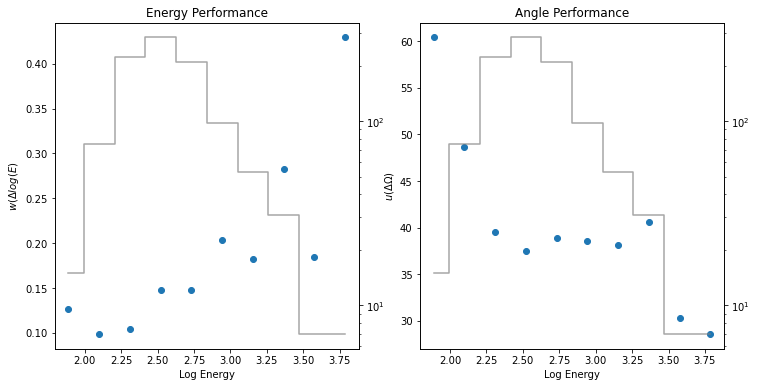

In [45]:
fig, ax = test_angle(loader_test)
if wandblog:
    fig.savefig(f"model_tests/{scenario}_test.pdf")

In [50]:
loader = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
loss = 0
prediction_list, target_list = [], []
for batch in loader:
    inputs, targets = batch
#     inputs[0][:, :3] = inputs[0][:, :3] / 1000
    predictions, targets, out = test_step(inputs, targets)
    loss           += out

    prediction_list.append(predictions)
    target_list.append(targets)
y_reco  = tf.concat(prediction_list, axis = 0).numpy()
y_true  = tf.concat(target_list, axis = 0)
y_true  = tf.cast(y_true, tf.float32).numpy()

In [51]:
res=y_reco-y_true

(array([19., 24., 23., 17., 19., 18., 22., 20., 21., 11., 17., 18., 21.,
        22., 24., 21., 17., 18., 12., 17., 27., 24., 13., 23., 22., 21.,
        19., 26., 21., 20., 26., 26., 26., 18., 20., 12., 19., 19., 29.,
        11., 20., 16., 17., 15., 18., 32., 21., 27., 17., 14.]),
 array([5.0240743e-04, 1.2613012e-01, 2.5175783e-01, 3.7738556e-01,
        5.0301325e-01, 6.2864095e-01, 7.5426871e-01, 8.7989640e-01,
        1.0055242e+00, 1.1311518e+00, 1.2567796e+00, 1.3824072e+00,
        1.5080349e+00, 1.6336627e+00, 1.7592903e+00, 1.8849181e+00,
        2.0105457e+00, 2.1361735e+00, 2.2618012e+00, 2.3874290e+00,
        2.5130568e+00, 2.6386843e+00, 2.7643120e+00, 2.8899398e+00,
        3.0155675e+00, 3.1411953e+00, 3.2668228e+00, 3.3924506e+00,
        3.5180783e+00, 3.6437061e+00, 3.7693338e+00, 3.8949616e+00,
        4.0205894e+00, 4.1462169e+00, 4.2718444e+00, 4.3974724e+00,
        4.5230999e+00, 4.6487279e+00, 4.7743554e+00, 4.8999834e+00,
        5.0256109e+00, 5.1512384e+00

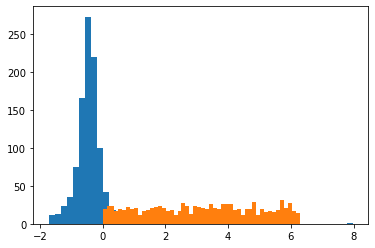

In [52]:
plt.hist(y_reco[:,2], bins=50)
plt.hist(y_true[:,2], bins=50)

In [ ]:
def test(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()


#     # Unit vects to angles
#     reco_vects = normalize(y_reco[:, 1:])    
#     true_vects = normalize(y_true[:, 1:])


#     reco_azi   = np.arctan2(reco_vects[:, 1], reco_vects[:, 0])
#     reco_zen   = np.arctan2(reco_vects[:, 2], np.sqrt((reco_vects[:, :2] ** 2).sum(1)))

#     true_azi   = np.arctan2(true_vects[:, 1], true_vects[:, 0])
#     true_zen   = np.arctan2(true_vects[:, 2], np.sqrt((true_vects[:, :2] ** 2).sum(1)))





    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)


    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))

    for a in ax[0]:
        a_ = a.twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        a.set_xlabel("Log Energy")
    
    ax_top = ax[0]

    # Energy reconstruction
    ax_top[0].scatter(xs, w_energies)
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$w(\Delta log(E)$")


    # Angle reconstruction
    ax_top[1].scatter(xs, u_angles)
    ax_top[1].set_title("Angle Performance")
    ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")


    # truth - pred plots
    ax_mid = ax[1]

    # Energy
    ax_mid[0].set_title("Energy")
    ax_mid[0].plot(y_true[:, 0], y_reco[:, 0], 'b.', alpha = 0.25)


    # Zenith
    ax_mid[1].set_title("Zenith angle")
    ax_mid[1].plot(true_zen, reco_zen, 'b.', alpha = 0.25)
    

    # Azimuthal
    ax_mid[2].set_title("Azimuthal angle")
    ax_mid[2].plot(true_azi, reco_azi, 'b.', alpha = 0.25)





    # Histogram of guesses
    ax_bot = ax[2]

    # Energy
    ax_bot[0].set_title("Energy")
    ax_bot[0].hist(y_reco[:, 0] - y_true[:, 0], label = "reco - true", histtype = "step", bins = 50)
    ax_bot[0].hist(y_reco[:, 0], label = "reco", histtype = "step", bins = 50)
    ax_bot[0].hist(y_true[:, 0], label = "true", histtype = "step", bins = 50)

    # Zenith
    ax_bot[1].set_title("Zenith angle")
    ax_bot[1].hist(reco_zen - true_zen, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[1].hist(reco_zen, label = "reco", histtype = "step", bins = 50)
    ax_bot[1].hist(true_zen, label = "true", histtype = "step", bins = 50)

    # Azimuthal
    ax_bot[2].set_title("Azimuthal angle")
    ax_bot[2].hist(reco_azi - true_azi, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[2].hist(reco_azi, label = "reco", histtype = "step", bins = 50)
    ax_bot[2].hist(true_azi, label = "true", histtype = "step", bins = 50)
    ax_bot[2].legend()

    fig.tight_layout()

    return fig, ax

In [16]:
def test(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()


#     # Unit vects to angles
#     reco_vects = normalize(y_reco[:, 1:])    
#     true_vects = normalize(y_true[:, 1:])


#     reco_azi   = np.arctan2(reco_vects[:, 1], reco_vects[:, 0])
#     reco_zen   = np.arctan2(reco_vects[:, 2], np.sqrt((reco_vects[:, :2] ** 2).sum(1)))

#     true_azi   = np.arctan2(true_vects[:, 1], true_vects[:, 0])
#     true_zen   = np.arctan2(true_vects[:, 2], np.sqrt((true_vects[:, :2] ** 2).sum(1)))





    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)


    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))

    for a in ax[0]:
        a_ = a.twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        a.set_xlabel("Log Energy")
    
    ax_top = ax[0]

    # Energy reconstruction
    ax_top[0].scatter(xs, w_energies)
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$w(\Delta log(E)$")


    # Angle reconstruction
    ax_top[1].scatter(xs, u_angles)
    ax_top[1].set_title("Angle Performance")
    ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")


    # truth - pred plots
    ax_mid = ax[1]

    # Energy
    ax_mid[0].set_title("Energy")
    ax_mid[0].plot(y_true[:, 0], y_reco[:, 0], 'b.', alpha = 0.25)


    # Zenith
    ax_mid[1].set_title("Zenith angle")
    ax_mid[1].plot(true_zen, reco_zen, 'b.', alpha = 0.25)
    

    # Azimuthal
    ax_mid[2].set_title("Azimuthal angle")
    ax_mid[2].plot(true_azi, reco_azi, 'b.', alpha = 0.25)





    # Histogram of guesses
    ax_bot = ax[2]

    # Energy
    ax_bot[0].set_title("Energy")
    ax_bot[0].hist(y_reco[:, 0] - y_true[:, 0], label = "reco - true", histtype = "step", bins = 50)
    ax_bot[0].hist(y_reco[:, 0], label = "reco", histtype = "step", bins = 50)
    ax_bot[0].hist(y_true[:, 0], label = "true", histtype = "step", bins = 50)

    # Zenith
    ax_bot[1].set_title("Zenith angle")
    ax_bot[1].hist(reco_zen - true_zen, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[1].hist(reco_zen, label = "reco", histtype = "step", bins = 50)
    ax_bot[1].hist(true_zen, label = "true", histtype = "step", bins = 50)

    # Azimuthal
    ax_bot[2].set_title("Azimuthal angle")
    ax_bot[2].hist(reco_azi - true_azi, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[2].hist(reco_azi, label = "reco", histtype = "step", bins = 50)
    ax_bot[2].hist(true_azi, label = "true", histtype = "step", bins = 50)
    ax_bot[2].legend()

    fig.tight_layout()

    return fig, ax

In [17]:
test(loader_test)

IndexError: index 2 is out of bounds for axis 1 with size 2